# Rozpoznawanie udzielenia pożyczki przez bank (Bank Loan Classification)

## 1. Opis problemu

Celem projektu jest przewidzenie czy bank udzieli pożyczki w opraciu o dane osoby. Dane wykorzystywane do projektu pochodzą z serwisu Kaggle, można je znaleźć pod adresem https://www.kaggle.com/sriharipramod/bank-loan-classification. Zawierają one informacje o osobach, które ubiegały się o udzelenie pożyczki przez bank oraz decyzję banku. 

## 2. Podstawowa analiza zbioru danych

Analizowany zbiór danych posiada następujące atrybuty:

*  **id** - numer przydzielony osobie
*  **Age** - wiek osoby starającej się o pożyczkę
* **Experience** - czas posiadania konta bankowego przez osobę (w latach)
* **Income** - roczne przychody osoby (w tysiącach dolarów)
* **ZIP Code** - kod pocztowy osoby
* **Family** - liczba członków najbliższej rodziny osoby
* **CCAvg** - średnie miesięczne wydatki z karty kredytowej osoby (w tysiącach dolarów)
* **Education** - liczbowy wskaźnik edukacji osoby
* **Mortgage** - wysokość posiadanego kredytu hipotecznego (w tysiącach dolarów)
* **Personal Loan** - liczbowa reprezentacja informacji czy bank udzielił pożyczki (0 lub 1)
* **Securities Account** - liczbowa reprezentacja informacji czy osoba posiada 
* **CD Account** - liczbowa reprezentacja informacji czy osoba posiada certyfikat depozytowy (0 lub 1)
* **Online** - liczbowa reprezentacja informacji czy osoba posiada konto internetowe w banku (0 lub 1)
* **CreditCard** - liczbowa reprezentacja informacji czy osoba posiada kartę kredytową (0 lub 1)


### Przygotowanie środowiska
Pakiety które będą potrzebne do analizy zbioru:

In [24]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.naive_bayes import GaussianNB
from sklearn import tree

### Wczytanie zbioru danych

In [25]:
df_org = pd.read_csv("UniversalBank.csv") 

Orginalny zbiór danych będzie znajdował się w ramce danych "df_org".

### Podstawowe parametry danych
Po wczytaniu zbioru można sprawdzić czy nie występują w nim żadne braki:

In [26]:
liczbaBrakujacychElementow = df_org.isnull().sum().sum()
print(f"Liczba brakujących elementów: {liczbaBrakujacychElementow}")

Liczba brakujących elementów: 0


Analizowany zbiór danych nie zawiera żadnych pustych komórek w związku z czym nie trzeba usuwać żadnych wierszy lub kolumn. Następnie można zliczyć ilość obiektów oraz atrybutów je opisujących.

In [27]:
lObiektow = df_org.shape[0]
lAtrybutow = df_org.columns.size

print("Liczba obiektów: " + str(lObiektow))
print("Liczba atrybutów: " + str(lAtrybutow))
print("Jeden z atrybutów jest atrybutem decyzyjnym, zatem pozostaje 13 atrybutów do analizy")

Liczba obiektów: 5000
Liczba atrybutów: 14
Jeden z atrybutów jest atrybutem decyzyjnym, zatem pozostaje 13 atrybutów do analizy


Typ wczytanych danych prezentuje się następująco:

In [28]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 546.9 KB


Wszystkie dane są typu liczbowego - 13 atrybutów jest typu int64, jeden atrybut (CCAvg) jest typu float64. Ponieważ wszystkie dane są typu liczbowego to nie jest konieczna ich konwersja.

Wyświetlenie początku oraz końca ramki danych w celu lepszego zobrazowania: 

In [29]:
df_org.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [30]:
df_org.tail()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


Jako, że atrybut 'Personal Loan' jest atrybutem decyzyjnym korzystnym dla późniejszej analizy będzie umieszczenie go jako ostatnią kolumnę ramki danych. Atrybuty 'ID' oraz 'ZIP Code' można usunąć z ramki danych, ponieważ są one nieistotne dla rozpatrywanego problemu przydzielania kredytu.

Następnie można zbadać podstawowe miary statystyczne zbioru danych:

In [31]:
df_org.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Jak widać jedynie 9.6% osób otrzymuje spełnia warunki banku i otrzymuje pożyczkę.

#### Wnioski z podstawowej analizy zbioru danych: (TODO)
* Atrybuty 'ID' oraz 'ZIP Code' można usunąć z ramki danych.
* Wszystkie atrybuty są liczbowe
* To dość duży zbiór danych z dużą ilością atrybutów - warto zwrócić uwagę czy wszystkie będą potrzebne do przeprowadzenia klasyfikacji

## 3. Przygotowanie zbioru do dalszej analizy

Nowa ramka danych będzie nosiła nazwę 'df'. W stosunku do ramki oryginalnej będzie się różniła następująco: zostaną z niej usunięte dwa atrybuty 'ID' i 'ZIP Code' oraz atrybut decyzyjny zostanie umieszczony w ostatniej kolumnie.

Kod wykonujące opisane powyżej operacje:

In [32]:
df = df_org.copy()
df = df.drop(columns = ['ID', 'ZIP Code'])
#columnsLabel = list(list(df))
#print(columnsLabel)
df = df[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard','Personal Loan']]

Ramka danych 'df' prezentuje się następująco:

In [33]:
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,25,1,49,4,1.6,1,0,1,0,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1,0


## 4. Wizualizacja i dalsza analiza danych

Zwizualizowanie danych znajdujących się w ramce ułatwi dalszą analizę ramki danych.

Ilość ludzi którym został przydzielony kredyt można przedstawić w postaci histogramu:

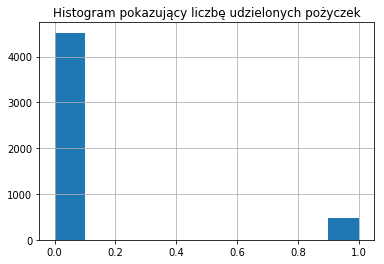

In [34]:
df['Personal Loan'].hist()
plt.title('Histogram pokazujący liczbę udzielonych pożyczek');

Liczbowo te dane prezentują się następująco:

In [35]:
print("Liczba nieprzydzielonych i przydzielonych pożyczek [0 1] - " + str(np.asarray(df.groupby('Personal Loan').Age.count())))

Liczba nieprzydzielonych i przydzielonych pożyczek [0 1] - [4520  480]


Podział zbioru można przedstawić na macierzy wykresów punktowych. Pozwoli to zobaczyć jak dzieli się zbiór w zależności od różnych atrybutów przyjętych jako współrzędne. Uwidoczni to korelację między atrybutami.

C:\Users\matik\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\matik\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


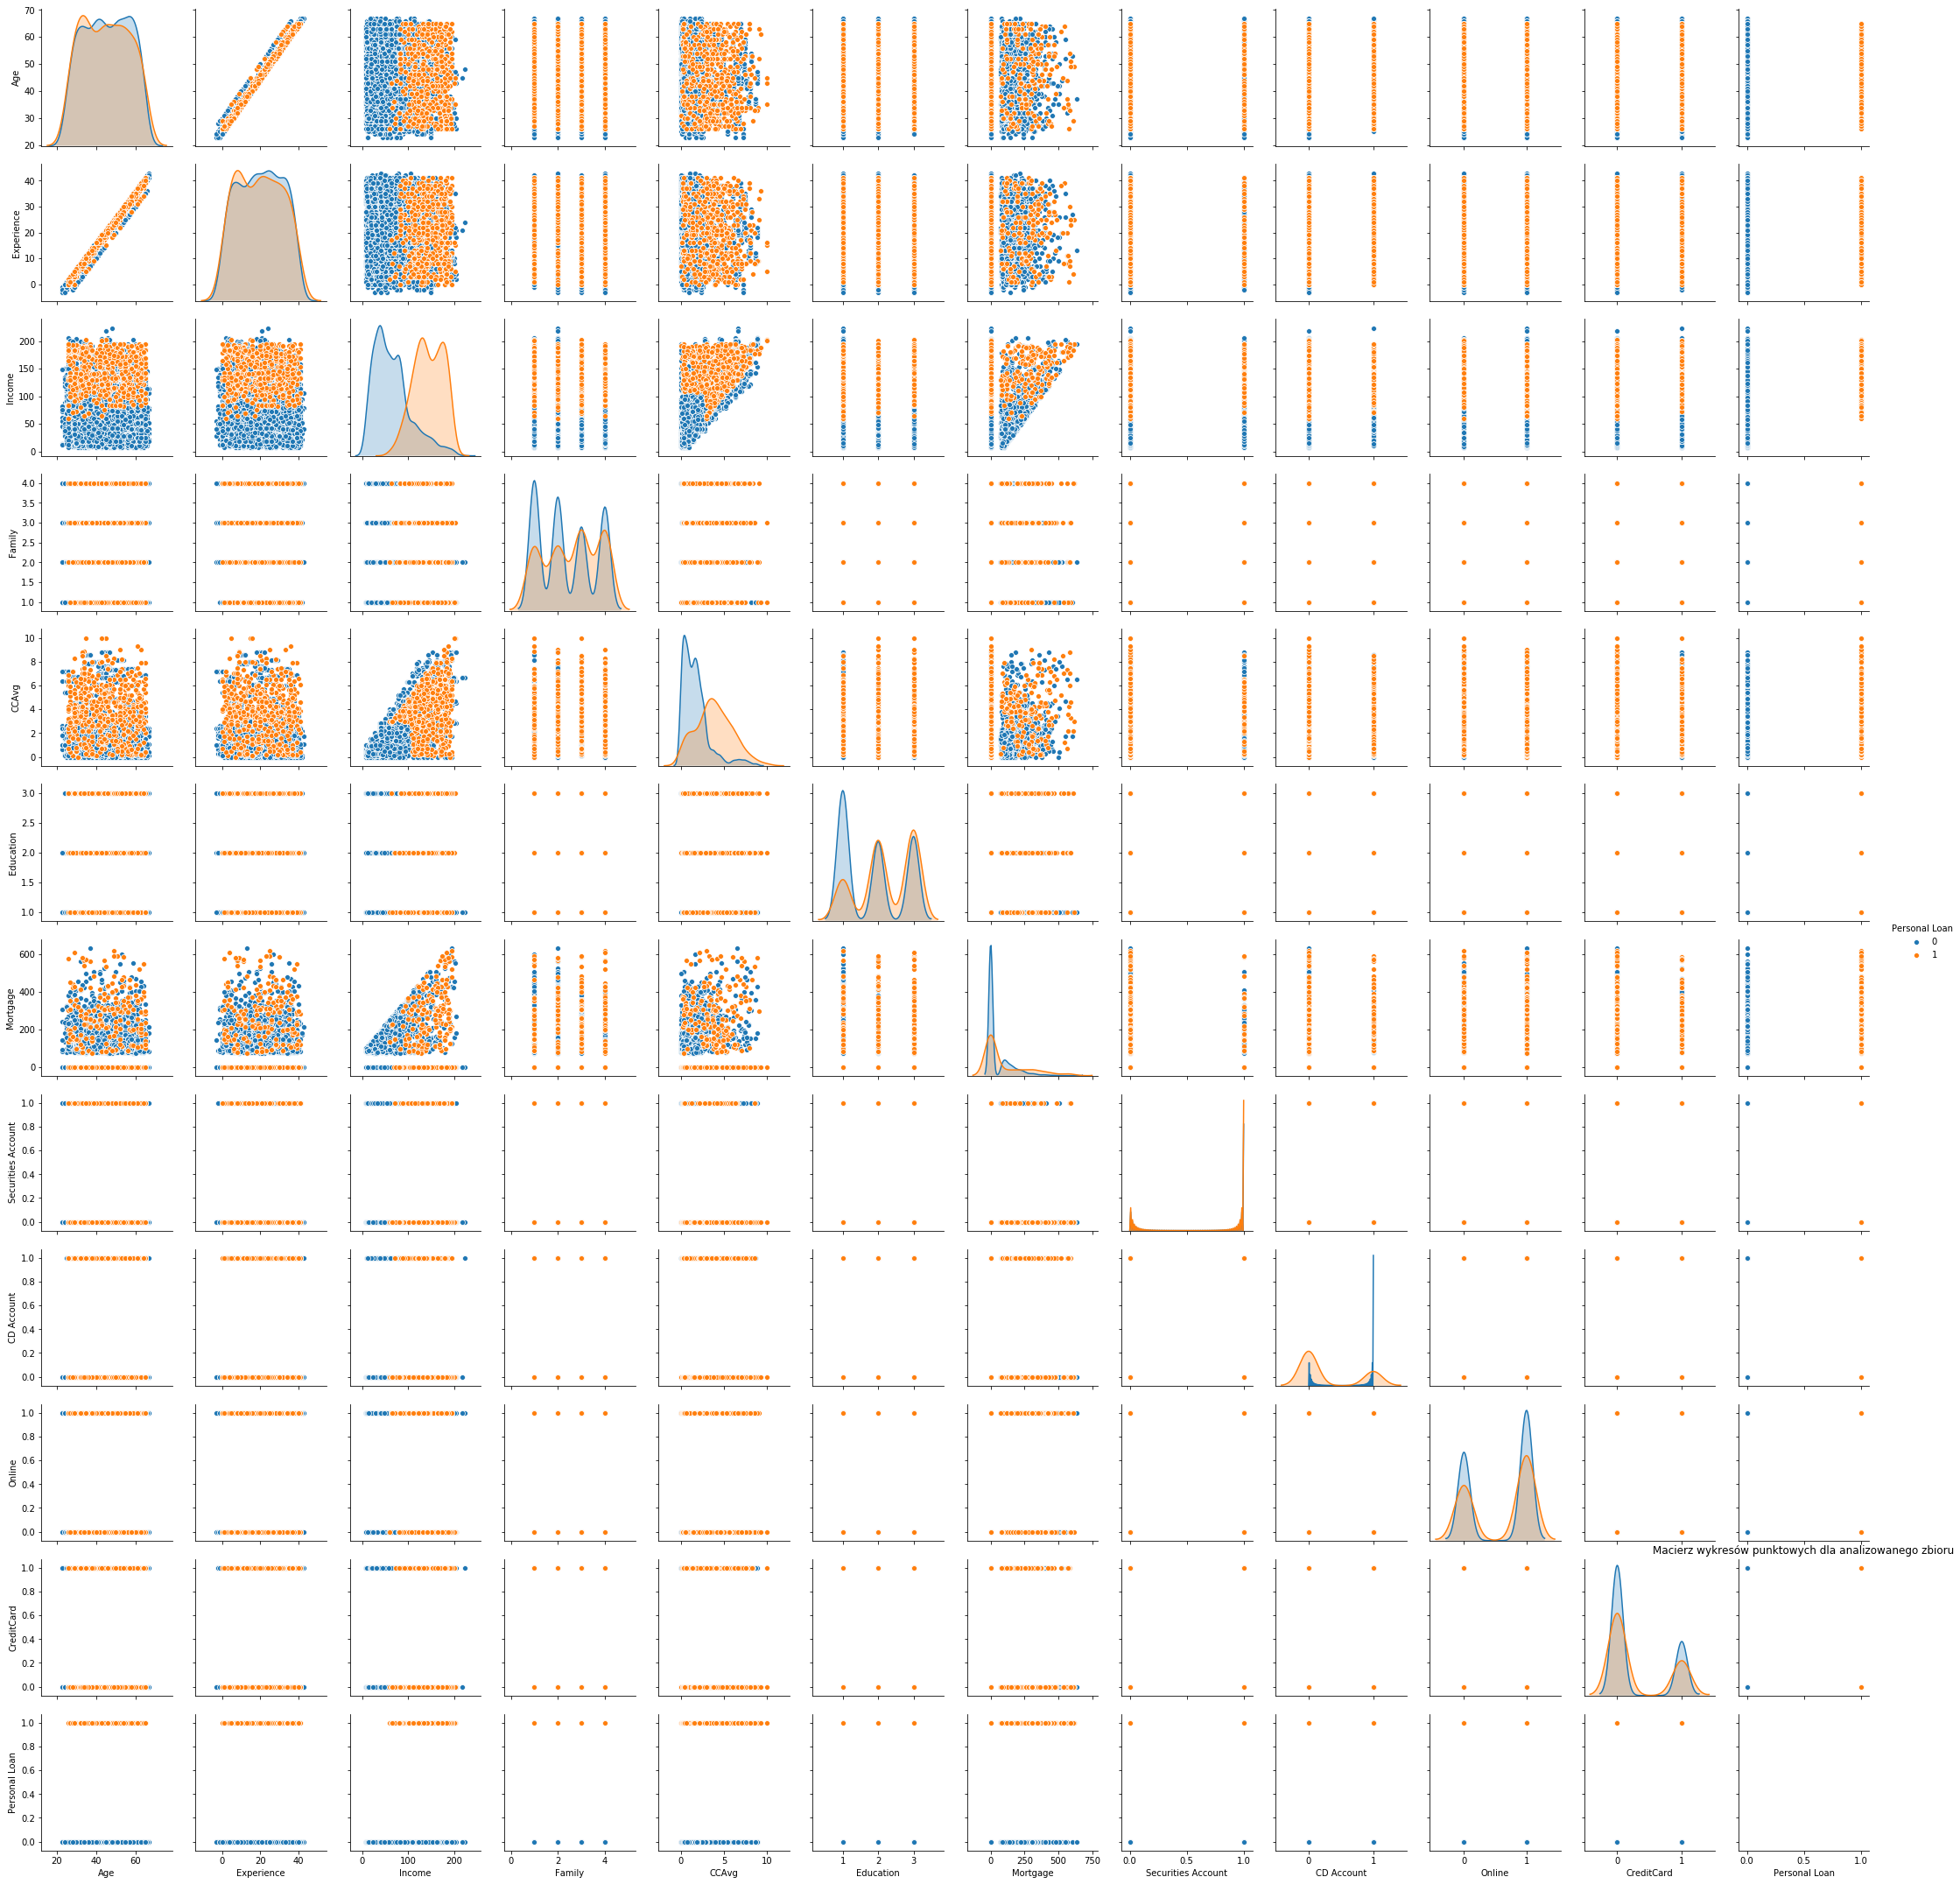

In [13]:
sns.pairplot(df, hue='Personal Loan')
plt.title("Macierz wykresów punktowych dla analizowanego zbioru")
plt.show()

Korelację można dokładniej przedstawić w postaci macierzy korelacji. 

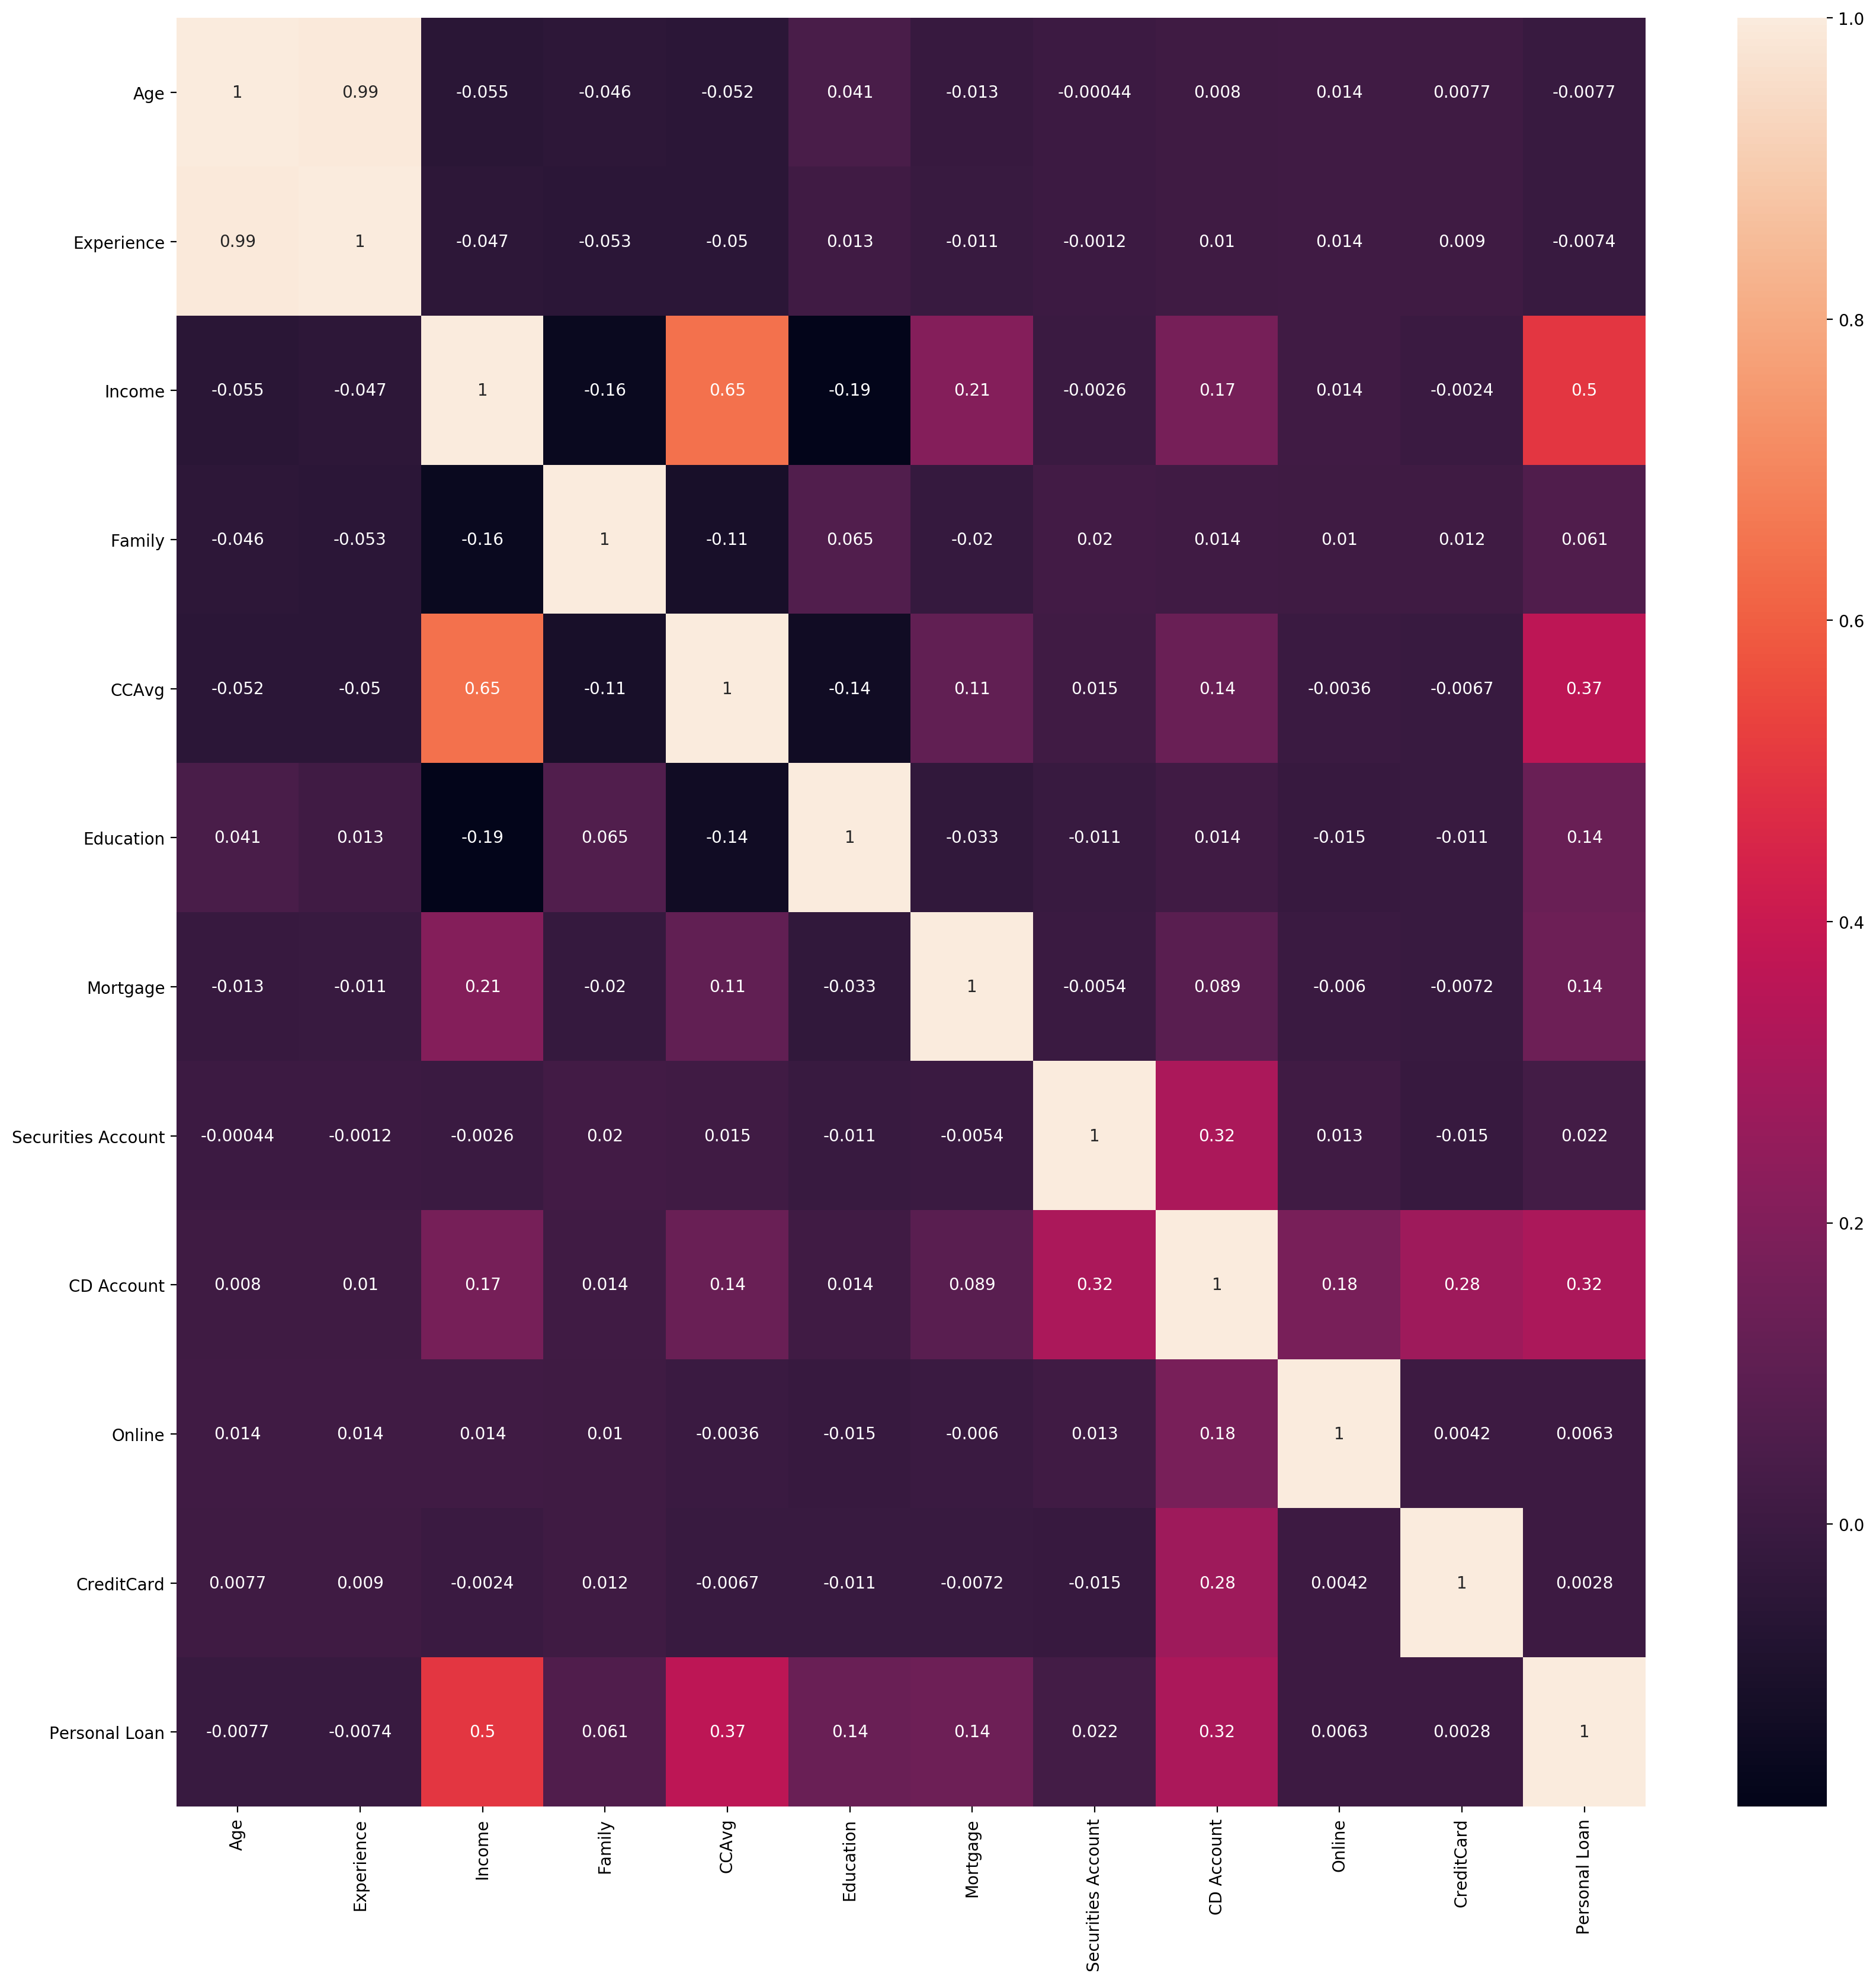

In [14]:
plt.figure(figsize=(20,20), dpi = 200)
sns.heatmap(df.corr(), annot = df.corr())

Z całej macierzy dla analizowanego problemu potrzebujemy tylko wiersz korelacji atrybuto 'Personal Loan' z pozostałymi atrybutami. Prezentuje się on następująco:

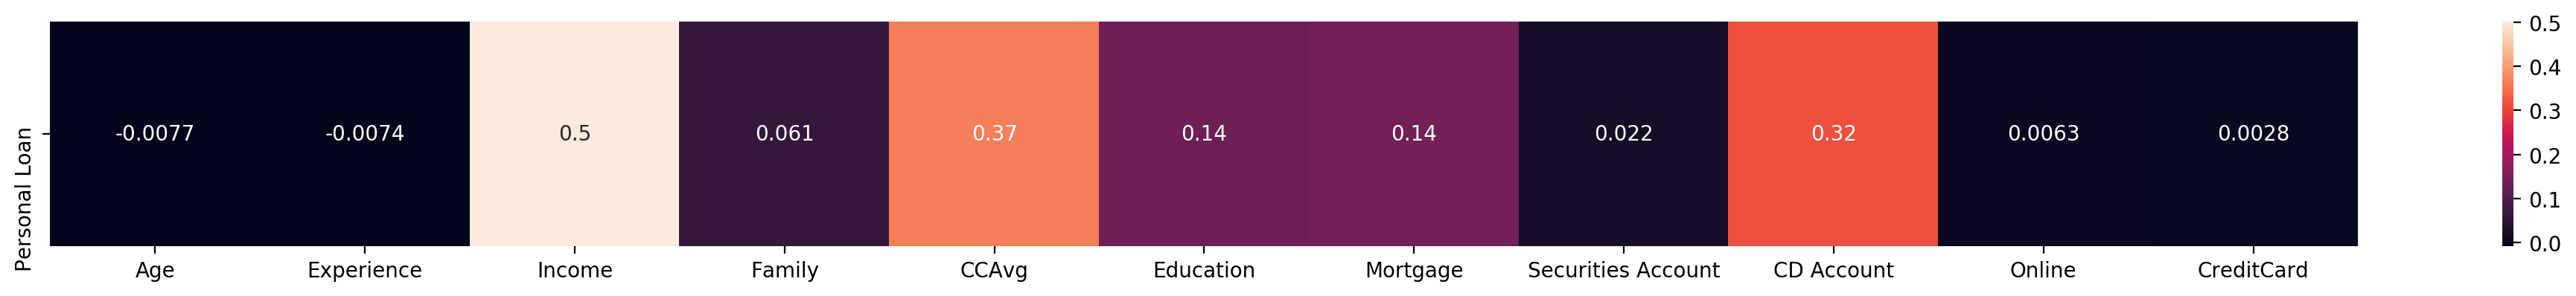

In [36]:
loanCorrelation = df.corr().iloc[11:12 , 0:]

loanCorrelation = loanCorrelation.drop(columns=['Personal Loan'])
plt.figure(figsize = (25, 2), dpi = 200)
sns.heatmap(loanCorrelation, annot = loanCorrelation)

Wartości korelacji poszczególnych atrybutów z atrybutem decyzyjnym można przedstawić w posortowanej tabeli w celu łatwiejszego przeanalizowania które atrybuty mają największy wpływ na pozytywne rozpatrzenie decyzji i przydzieleniu pożyczki. 

In [37]:
sortedLoanCorrelation = loanCorrelation.mean()
sortedLoanCorrelation = sortedLoanCorrelation.sort_values(ascending = False)
sortedLoanCorrelation = pd.DataFrame(sortedLoanCorrelation, columns=['Korelacja atrybutów z przydzieleniem kredytu'])

print(sortedLoanCorrelation)

                    Korelacja atrybutów z przydzieleniem kredytu
Income                                                  0.502462
CCAvg                                                   0.366889
CD Account                                              0.316355
Mortgage                                                0.142095
Education                                               0.136722
Family                                                  0.061367
Securities Account                                      0.021954
Online                                                  0.006278
CreditCard                                              0.002802
Experience                                             -0.007413
Age                                                    -0.007726


Jak widać zdecydowanie największy wpływ na udzielenie pożyczki ma **Income** czyli roczny dochód klienta banku. Bardzo duży wpływ na decyzję maja też atrybuty **CCAvg** oraz **CD Account**. Atrybuty **Age**, **Experience**, **CreditCard** oraz **Online** mają znikomy wpływ na decyzję banku z powodu bardzo niskiego współczynnika korelacji z Personal Loan. 

W związku z niskim współczynnikiem korelacji atrybutów Age, Experience, CreditCard, oraz Online można uznać za nie znaczące i zostaną one pominięte przy klasyfikacji. Nową ramką danych bez tych atrybutów będzie **df_short**.

In [38]:
atrSh = list(list(sortedLoanCorrelation.index[:7]))
df_short = df[atrSh + [df.columns[11]]]
print("Ramka df_short:")
df_short.head()

Ramka df_short:


,Income,CCAvg,CD Account,Mortgage,Education,Family,Securities Account,Personal Loan
0,49,1.6,0,0,1,4,1,0
1,34,1.5,0,0,1,3,1,0
2,11,1.0,0,0,1,1,0,0
3,100,2.7,0,0,2,1,0,0
4,45,1.0,0,0,2,4,0,0


## 5. Analiza grupowania danych

## 6. Testy klasyfikatorów

Klasyfikacja zostanie wykonana na ramce danych df_short, która zawiera wszystkie atrybuty znaczące.

### Przygotowanie potrzebnych funkcji

Żeby można było sprawdzić dany klasyfikator zbiór danych należy podzielić na uczący i testowy. Funkcja to realizująca:

In [39]:
def podziel(df,proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

Kolejną potrzebną funkcją będzie funkcja weryfikująca jakość klasyfikacji. Funkcja ta będzie prezentowała jakość klasyfikacji w postaci macierzy pomyłek oraz wynikających z niej dwóch wskaźników: jakości klasyfikacji oraz poziomu błędu.

In [40]:
def weryfikuj(model,dane,atryb):
    # wyswietla wynik weryfikacji klasyfikatora w postaci macierzy pomyłek
    # dla zbioru uczącego i testowego
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atryb - lista atrybutów uwzględnianych w weryfikacji
    #accUcz, accTest - wskaźnik jakości klasyfikacji dla zbioru uczącego/testowego
    #errUcz, errTest - wskaźnik poziomu błędu klasyfikacji dla zbioru uczącego/testowego
    model.fit(dane["opis_ucz"].iloc[:,atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:,atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:,atryb])
    tabUcz = pd.crosstab(dane["dec_ucz"],wynik_ucz)
    tabTest = pd.crosstab(dane["dec_test"],wynik_test)
    
    print(tabUcz.info())
    
    accUcz = (tabUcz.iloc[0,0] + tabUcz.iloc[1,1])/(len(dane["opis_ucz"]))
    errUcz = (tabUcz.iloc[0,1] + tabUcz.iloc[1,0])/(len(dane["opis_ucz"]))
    accTest = (tabTest.iloc[0,0] + tabTest.iloc[1,1])/(len(dane["opis_test"]))
    errTest = (tabTest.iloc[0,1] + tabTest.iloc[1,0])/(len(dane["opis_test"]))
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(dane["dec_ucz"],wynik_ucz)) 
    print("Jakość klasyfikacji dla zbioru uczącego:" + str(accUcz))
    print("Poziom błędu dla zbioru uczącego:" + str(errUcz))
    print("Macierz pomyłek dla zbioru testowego")
    print(pd.crosstab(dane["dec_test"],wynik_test)) 
    print("Jakość klasyfikacji dla zbioru testowego:" + str(accTest))
    print("Poziom błędu dla zbioru testowego:" + str(errTest))
    return accTest, errTest

Przydatną też funkcją będzie funkcja służąca do rysownia uzyskanej klasyfikacji w przestrzeni atrybutów z uwzględnieniem granic decyzyjnych. 

In [58]:
def granice(model,dane,atr_x, atr_y,tytul,kontur = 1):
    # wyswietla granice decyzyjne
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atr_x/atr_y - artybut wyswietlany na osi x/y
    # tytul - wyswietlany tytul wykresu
    # kontur - par. opcjonalny (=0 -> brak konturu)
    if (kontur == 1):    
        model.fit(dane["opis_ucz"].iloc[:,[atr_x,atr_y]], dane["dec_ucz"])
        x_min = min(dane["opis_ucz"].iloc[:, atr_x].min(),dane["opis_test"].iloc[:, atr_x].min())
        x_max = max(dane["opis_ucz"].iloc[:, atr_x].max(),dane["opis_test"].iloc[:, atr_x].max())
        y_min = min(dane["opis_ucz"].iloc[:, atr_y].min(),dane["opis_test"].iloc[:, atr_y].min())
        y_max = max(dane["opis_ucz"].iloc[:, atr_y].max(),dane["opis_test"].iloc[:, atr_y].max())
        rozst_x = x_max - x_min
        rozst_y = y_max - y_min
        x_min = x_min - 0.1*rozst_x
        x_max = x_max + 0.1*rozst_x
        y_min = y_min - 0.1*rozst_y
        y_max = y_max + 0.1*rozst_y       
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/150),
                     np.arange(y_min, y_max, (y_max-y_min)/150))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    plt.figure(dpi = 100)
    plt.title(tytul)
    if (kontur == 1):
        plt.contourf(xx, yy, Z, levels = 4, alpha=0.2)
    plt.scatter(dane["opis_ucz"].iloc[:, atr_x], dane["opis_ucz"].iloc[:, atr_y], c=dane["dec_ucz"], marker = '.')
    plt.scatter(dane["opis_test"].iloc[:, atr_x], dane["opis_test"].iloc[:, atr_y], c=dane["dec_test"], marker = 'x')

**Podział zbioru danych na zbiór uczący i zbiór testowy:**

In [59]:
d_test = podziel(df_short,0.3)

#### Klasyfikator 1NN

Pierwszym zbadanym klasyfikatorem będzie klasyfikator 1NN.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      3146    0
1         0  354
Jakość klasyfikacji dla zbioru uczącego:1.0
Poziom błędu dla zbioru uczącego:0.0
Macierz pomyłek dla zbioru testowego
col_0     0   1
row_0          
0      1320  54
1        51  75
Jakość klasyfikacji dla zbioru testowego:0.93
Poziom błędu dla zbioru testowego:0.07


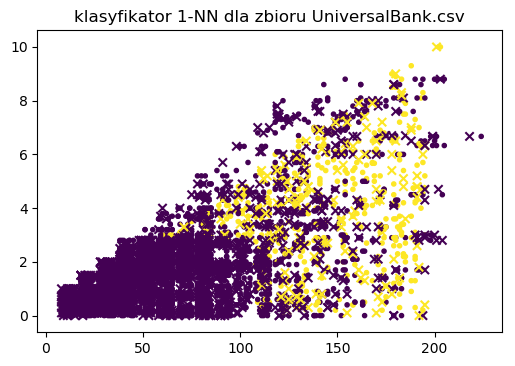

In [60]:
#Klasyfikator 1NN
nazwa_pliku = 'UniversalBank.csv'
# zdefiniowanie modelu klasyfikatora
model = KNeighborsClassifier(n_neighbors=1)
atr = [0,1,2,3,4,5,6]
# wybór atrybutów
ax, ay = 0,1
# granice dycyzyjne
granice(0,d_test,0,1,"klasyfikator 1-NN dla zbioru " + nazwa_pliku,0)
# weryfikacja
onnAcc, onnErr = weryfikuj(model,d_test,atr)

Przy wykorzystaniu klasyfikatora 1NN udało się uzyskać przyzwoitą jakość klasyfikacji na poziomie 90% oraz błąd wynoszący około 9.5%. 

#### Klasyfikator k-NN

Analiza klasyfikator k-NN zostanie wykonana dla k = 1,3,5,9. Wszystkie warianty zostaną ze sobą porównane.


Dla k = 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      3146    0
1         0  354
Jakość klasyfikacji dla zbioru uczącego:1.0
Poziom błędu dla zbioru uczącego:0.0
Macierz pomyłek dla zbioru testowego
col_0     0   1
row_0          
0      1320  54
1        51  75
Jakość klasyfikacji dla zbioru testowego:0.93
Poziom błędu dla zbioru testowego:0.07

Dla k = 3

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      3109   37
1       105  249
Jakość klasyfikacji dla zbioru uczącego:0.9594285714285714
Poziom błędu dla zbioru uczącego:0.04057142857142857
Macierz

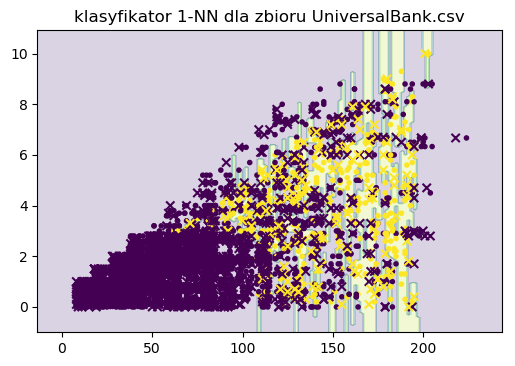

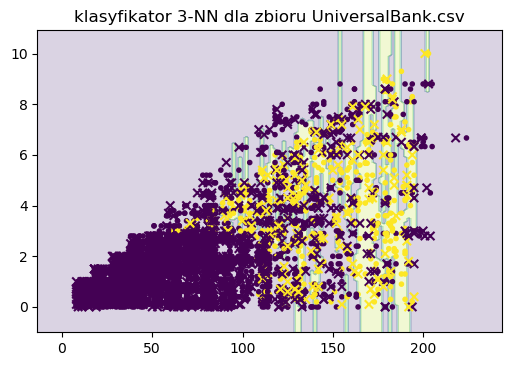

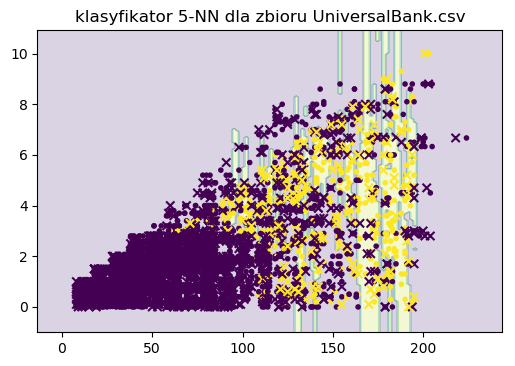

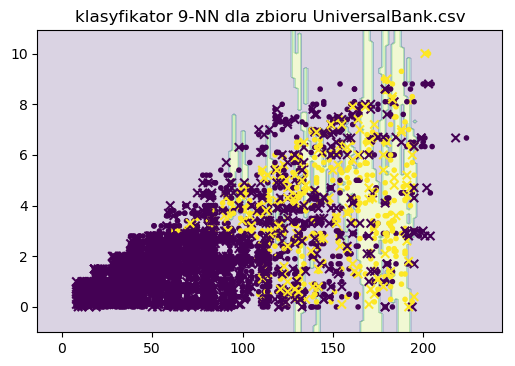

In [71]:
#Klasyfikator k-NN
i=0
kNNAcc = [0]*4
kNNErr= [0]*4
kNNvalues = [1,3,5,9]
for k in [1,3,5,9]:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    print("\nDla k = " + str(k)+"\n")
    granice(model_knn,d_test,0,1,"klasyfikator " + str(k)+ "-NN dla zbioru " + nazwa_pliku)
    kNNAcc[i], kNNErr[i] = weryfikuj(model_knn,d_test,atr)
    i = i + 1

Text(0, 0.5, 'Prawdopodobienstwo bledu')

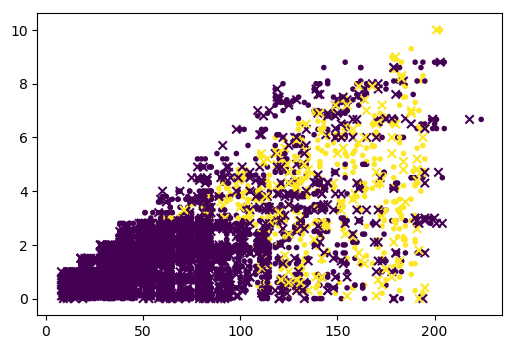

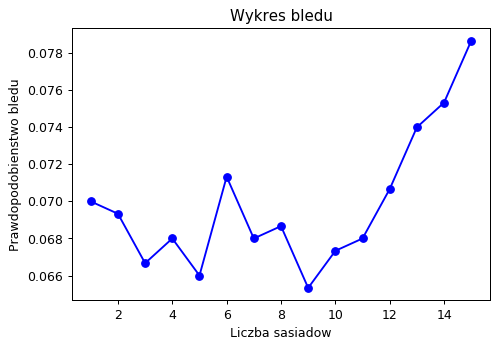

In [62]:
#Analiza błędu klasyfikacji dla k-NN
granice(model,d_test,0,1,"",0)
kvals = range(1, 16)
rss_all = np.zeros(15)
for k in kvals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(d_test['opis_ucz'],d_test['dec_ucz'])
    predictions = model.predict(d_test['opis_test'])
    rss_all[k-1] = 1-model.score(d_test['opis_test'],d_test['dec_test'])
plt.figure(dpi=90)
plt.plot(kvals, rss_all,'bo-')
plt.title('Wykres bledu')
plt.xlabel('Liczba sasiadow')
plt.ylabel('Prawdopodobienstwo bledu')

Jak widać najniższe prawdopodobieństwo błędu w metodzie k-NN wyszło dla k=3.

#### Metoda najbliższych prototypów

Kolejny przetestowanym klasyfikatorem będzie metoda najbliższego prototypu.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      2595  551
1       151  203
Jakość klasyfikacji dla zbioru uczącego:0.7994285714285714
Poziom błędu dla zbioru uczącego:0.20057142857142857
Macierz pomyłek dla zbioru testowego
col_0     0    1
row_0           
0      1111  263
1        60   66
Jakość klasyfikacji dla zbioru testowego:0.7846666666666666
Poziom błędu dla zbioru testowego:0.21533333333333332


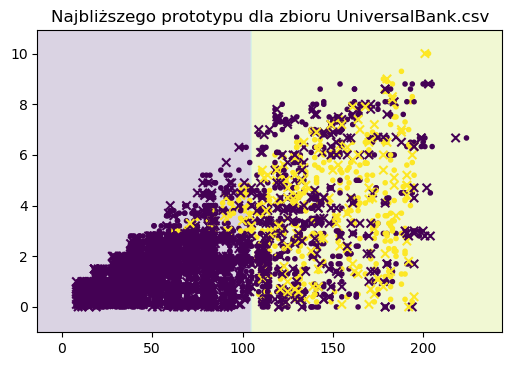

In [72]:
#Metoda najbliższych prototypów
model = NearestCentroid()
# granice dycyzyjne
granice(model,d_test,0,1,"Najbliższego prototypu dla zbioru " + nazwa_pliku)
# weryfikacja
npAcc, npErr = weryfikuj(model,d_test,atr)

#### Naiwny klasyfikator Bayesa

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      2881  265
1       139  215
Jakość klasyfikacji dla zbioru uczącego:0.8845714285714286
Poziom błędu dla zbioru uczącego:0.11542857142857142
Macierz pomyłek dla zbioru testowego
col_0     0    1
row_0           
0      1256  118
1        57   69
Jakość klasyfikacji dla zbioru testowego:0.8833333333333333
Poziom błędu dla zbioru testowego:0.11666666666666667


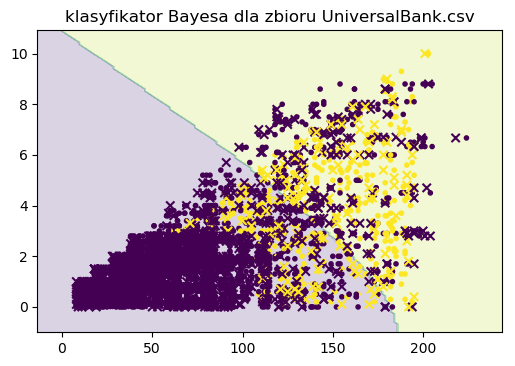

In [73]:
#Naiwny klasyfikator Bayesa
model = GaussianNB()
# granice dycyzyjne
granice(model,d_test,0,1,"klasyfikator Bayesa dla zbioru " + nazwa_pliku)
# weryfikacja
gnbAcc, gnbErr = weryfikuj(model,d_test,atr)

#### Klasyfikacja drzewami decyzyjnymi


Głębokość: 2

drzewo o głębokości 2 dla zbioru UniversalBank.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      2881  265
1       139  215
Jakość klasyfikacji dla zbioru uczącego:0.8845714285714286
Poziom błędu dla zbioru uczącego:0.11542857142857142
Macierz pomyłek dla zbioru testowego
col_0     0    1
row_0           
0      1256  118
1        57   69
Jakość klasyfikacji dla zbioru testowego:0.8833333333333333
Poziom błędu dla zbioru testowego:0.11666666666666667

Głębokość: 3

drzewo o głębokości 3 dla zbioru UniversalBank.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    

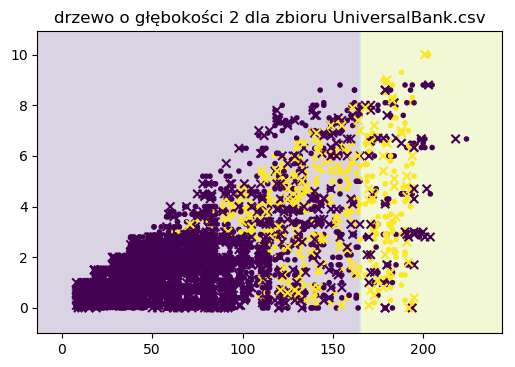

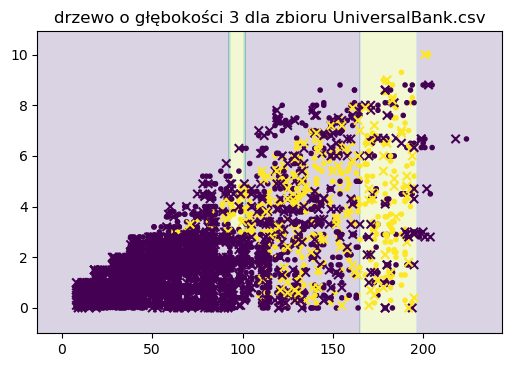

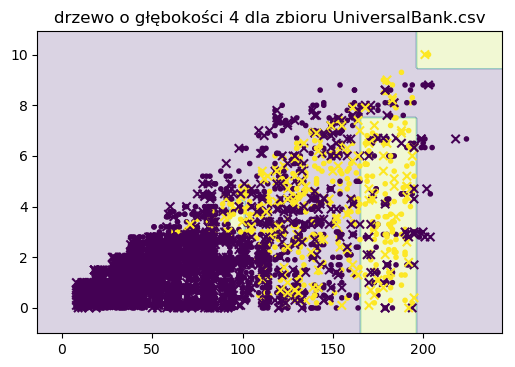

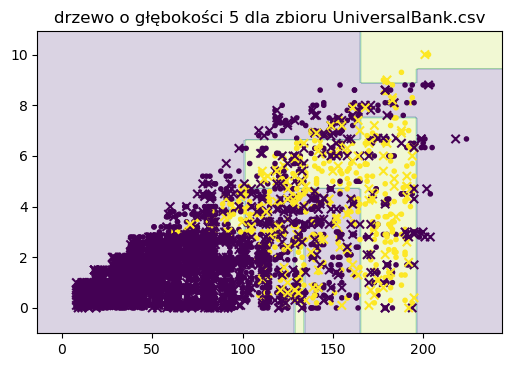

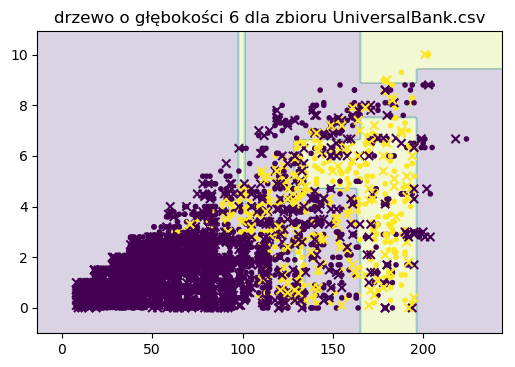

In [74]:
#Drzewa decyzyjne 
i=0;
dtAcc = [0]*5
dtErr = [0]*5
dtValues = [2,3,4,5,6]
for g in [2,3,4,5,6]:
    print("\nGłębokość: " + str(g) + "\n")
    drzewo = tree.DecisionTreeClassifier(max_depth=g)
    tekst = "drzewo o głębokości " + str(g) + " dla zbioru " + nazwa_pliku
    print(tekst)
    dtAcc[i], dtErr[i] = weryfikuj(model,d_test,atr)
    i = i + 1
    granice(drzewo ,d_test,0,1,tekst)

### Podsumowanie klasyfikatorów

Wyniki dokładności klasyfikacji dla poszczególnych klasyfikatorów prezentują się następująco:

In [75]:
print("Klasyfikator 1-NN:")
print("Jakość:" + str(onnAcc))
print("Błąd:" + str(onnErr))
print("Klasyfikator k-NN:")
for i in range(len(kNNvalues)): 
    print(str(kNNvalues[i])+"-NN:")
    print("Jakość:" + str(kNNAcc[i]))
    print("Błąd:" + str(kNNErr[i]))
print("Metoda najbliższych prototypów")
print("Jakość:" + str(npAcc))
print("Błąd:" + str(npErr))
print("Klasyfikator naiwny Bayesa")
print("Jakość:" + str(gnbAcc))
print("Błąd:" + str(gnbErr))
print("Klasyfikator drzew decyzyjnych")
for i in range(len(dtValues)): 
    print("Drzewo o głębokości = "+str(dtValues[i]))
    print("Jakość:" + str(dtAcc[i]))
    print("Błąd:" + str(dtErr[i]))


Klasyfikator 1-NN:
Jakość:0.93
Błąd:0.07
Klasyfikator k-NN:
1-NN:
Jakość:0.93
Błąd:0.07
3-NN:
Jakość:0.9333333333333333
Błąd:0.06666666666666667
5-NN:
Jakość:0.934
Błąd:0.066
9-NN:
Jakość:0.9346666666666666
Błąd:0.06533333333333333
Metoda najbliższych prototypów
Jakość:0.7846666666666666
Błąd:0.21533333333333332
Klasyfikator naiwny Bayesa
Jakość:0.8833333333333333
Błąd:0.11666666666666667
Klasyfikator drzew decyzyjnych
Drzewo o głębokości = 2
Jakość:0.8833333333333333
Błąd:0.11666666666666667
Drzewo o głębokości = 3
Jakość:0.8833333333333333
Błąd:0.11666666666666667
Drzewo o głębokości = 4
Jakość:0.8833333333333333
Błąd:0.11666666666666667
Drzewo o głębokości = 5
Jakość:0.8833333333333333
Błąd:0.11666666666666667
Drzewo o głębokości = 6
Jakość:0.8833333333333333
Błąd:0.11666666666666667


#### Wnioski

Klasyfikatory typu *k-NN* okazały się najdokładniejsze spośród wszystkich badanych - wszystkie uzyskały jakość klasyfikacji na poziomie około 93% i błąd klasyfikacji wynoszący około 6,5%. Pozostałe metody osiągnęły dokładność poniżej 90%. Najmniej dokładna okazała się *metoda najbliższych prototypów*, która osiągnęła ledwo 78%. 

W przypadku *drzew decyzyjnych* dokładność klasyfikacji okazała się taka sama niezależnie od głębokości drzewa.

W przypadku *metody kNN* dokładność klasyfikacji nieznacznie wzrosła wraz ze wzrostem k.

#### Klasyfikacja przy użyciu pełnego zbioru

In [76]:
d_test_full = podziel(df,0.3)

Wyniki sprawdzimy dla klasyfikacji 1-NN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
0    2 non-null int64
1    2 non-null int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
Macierz pomyłek dla zbioru uczącego
col_0     0    1
row_0           
0      2866  293
1       289   52
Jakość klasyfikacji dla zbioru uczącego:0.8337142857142857
Poziom błędu dla zbioru uczącego:0.1662857142857143
Macierz pomyłek dla zbioru testowego
col_0     0    1
row_0           
0      1206  155
1       121   18
Jakość klasyfikacji dla zbioru testowego:0.816
Poziom błędu dla zbioru testowego:0.184


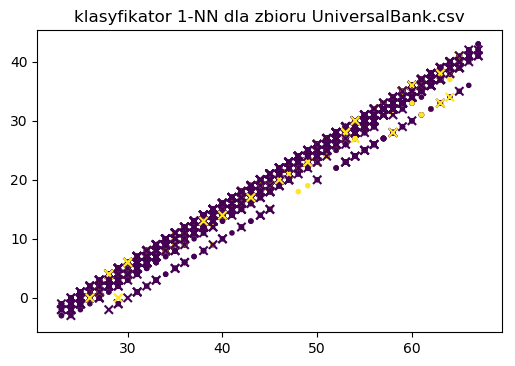

In [77]:
#Klasyfikator 1NN
nazwa_pliku = 'UniversalBank.csv'
# zdefiniowanie modelu klasyfikatora
model = KNeighborsClassifier(n_neighbors=1)
# wybór atrybutów
atr1=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
ax, ay = 0,1
# granice dycyzyjne
granice(0,d_test_full,0,1,"klasyfikator 1-NN dla zbioru " + nazwa_pliku,0)
# weryfikacja
onnAcc2, onnErr2 = weryfikuj(model,d_test_full,[ax,ay])

W wyniku zastosowania pełnego zbioru danych do klasyfikacji jakość spadła. Jak widać zdecydowanie lepiej jest wykorzystać ramkę danych *df_short* z której pozbyliśmy się atrybutów nie znaczących.

## Wnioski końcowe

* Najlepsza jakość klastfikacji, którą udało się nam osiągnąć to 93,4(6)% - kNN, gdzie k = 9. Ten wynik Jest zadowalający i dodatkowo znacznie lepszy od pozostałych o kila punktów procentowych.
* Zbiór danych był dość duży i posiadał aż 14 atrybutów, bez decyzyjnego 13. Po przeanalizowaniu zbioru okazało się jednak, że część atrybutów jest zupełnie zbędna jeśli chodzi o przyprowadzenie klasyfikacji.
* Najlepiej sprawdziła się metoda kNN, a najgorzej metoda najbliższych prototypów.